In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import grad
from torch.optim.lr_scheduler import ExponentialLR

from binarypredictor.datagen import PolyGenerator, DataGenerator
from binarypredictor.poly import Polynomial, PolynomialSet, PolynomialBatch, PolynomialDataLoader
from binarypredictor.net import DerivativeNet

In [2]:
# Create dataset
dg = DataGenerator()
dg.generate_data(20000)

polys = dg.get_polys()

batch_size = 200
train_loader = PolynomialDataLoader(polys, batch_size, shuffle=True)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:57<00:00, 67.11it/s]


In [4]:
out_features = 100

net = DerivativeNet(train=True, in_features=200, hidden_size_linear=256, out_features=out_features, hidden_layers=5)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
scheduler = ExponentialLR(optimizer, gamma=0.995)

In [5]:
low, high = 0., 1.

x_in = torch.arange(low, high, step=0.01 * (high - low))
x_out = torch.zeros((batch_size, out_features))
x_out[:] = torch.arange(low, high, step=1/out_features * (high - low))


for i in range(5000):
    for p in train_loader:
        inp = p.get_values(x_in, o=0, stack='v')
        out = net(inp.squeeze().float())
                        
        x_range = torch.stack((out, x_out), dim=2)
        p_vals = p.get_values(x_range, o=0)
        dp_vals = p.get_values(x_range, o=1)

        optimizer.zero_grad()
        loss_1 = nn.MSELoss()(p_vals[:, :, 0] - out * dp_vals[:, :, 0], p_vals[:, :, 1] - x_out * dp_vals[:, :, 1])
        loss_2 = nn.MSELoss()(dp_vals[:, :, 0], dp_vals[:, :, 1])
        loss = loss_1 + loss_2
        loss.backward(retain_graph=True)      
        optimizer.step()
    #scheduler.step()
    
    if i % 5 == 0:
        print(loss)

KeyboardInterrupt: 

In [6]:
#torch.save(net, 'binary_new.pth')

net = torch.load('binary_new.pth')

In [7]:
pg = PolyGenerator(2)
pg.add_constraint(0.5, 1, 0)
pg.add_constraint(0.1, 0, 1)
#pg.add_constraint(0.8, 0, 1)
pg.add_constraint(0.5, 0, 0)
#pg.add_constraint(0.9, 0, 5)
#pg.add_constraint(0.2, 0, 2.5)

qg = PolyGenerator(2)
qg.add_constraint(0.5, 1, 0)
qg.add_constraint(0.1, 0, 2)
qg.add_constraint(0.5, 0, -.2)
#qg.add_constraint(0.9, 1, -6)
#qg.add_constraint(0.9, 0, 8)
#qg.add_constraint(0.2, 0, 1.5)

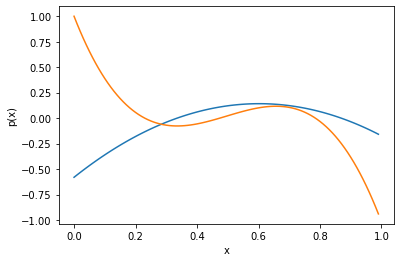

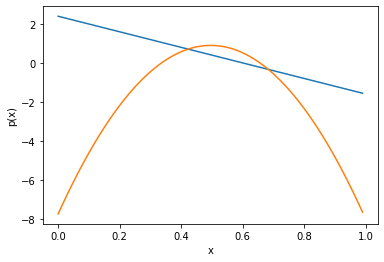

In [48]:
x_in = torch.arange(low, high, step=0.01 * (high - low))

poly_set = train_loader[0][0]
#poly_set = PolynomialSet() 
#poly_set.append(Polynomial(pg.get_cfs())) 
#poly_set.append(Polynomial(qg.get_cfs()))

d_poly_set = poly_set.get_derivatives()

poly_set.scale_by_max(x_in)
poly_set.plot(x_in)
plt.show()

d_poly_set.plot(x_in)
plt.show()

In [49]:
inp = poly_set.get_values(x_in, stack='v')

out = (net(inp.squeeze().float()))
x = torch.arange(0., 1., step=1/out_features)

x_range = torch.vstack((out, x)).T
dp_vals = d_poly_set.get_values(x_range)

#for d in dp_vals:
#    print(d)

#close = (dp_vals[:, 0] - dp_vals[:, 1] < .5e-1) & (dp_vals[:, 0] - dp_vals[:, 1] > -.5e-1)

dp_vals_ = dp_vals#[close]
out_ = out#[close]
x_ = x#[close]

valid_idx = torch.where((out_ >= 0) & (out_ <= 1))
out_ = out_[valid_idx]
x_ = x_[valid_idx]

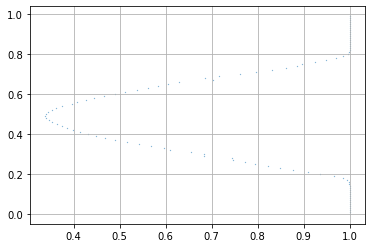

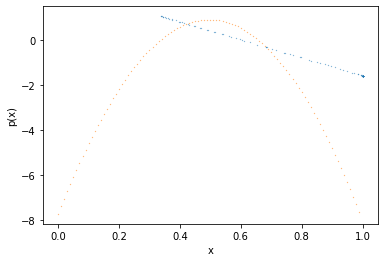

In [50]:
plt.scatter(out_.detach().numpy(), x_, s=.05)
plt.grid()
plt.show()

x_range_ = torch.vstack((out_, x_)).T
d_poly_set.plot(x_range, scatter=True)

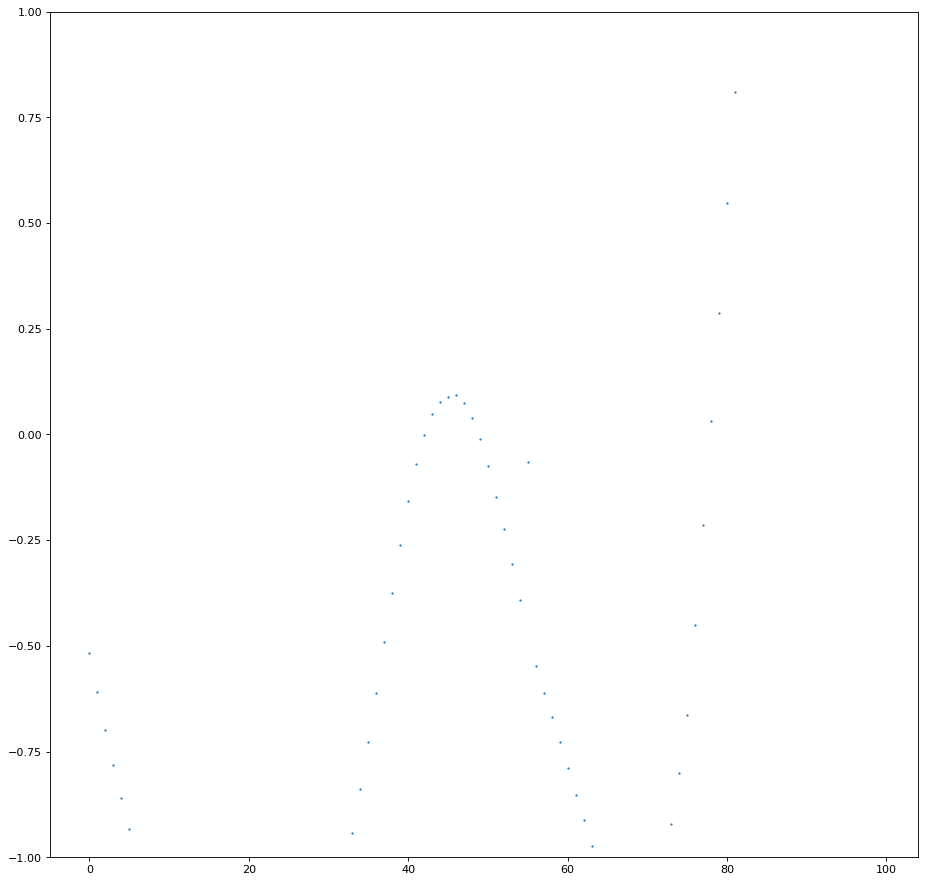

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1])
tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,
         1,  0,  0,  0])
tensor([10, 18])
tensor([[0.4260, 0.4700],
        [0.6166, 0.5500]], grad_fn=<IndexBackward0>)
tensor([[0.4580, 0.4800],
        [0.9935, 0.7600]], grad_fn=<IndexBackward0>)
[10.227226 17.477446]
floor:
 tensor([[0.4260, 0.4700],
        [0.6355, 0.5400]], grad_fn=<IndexBackward0>)
ceiling:
 tensor([[0.4580, 0.4800],
        [0.6166, 0.5500]], grad_fn=<IndexBackward0>)
tensor([[0.4333, 0.4723],
        [0.6265, 0.5448]])
tensor([-0.2851,  0.9006], grad_fn=<MvBackward0>)


<ipython-input-47-5fa924035c3a>:50: ComplexWarning: Casting complex values to real discards the imaginary part
  roots_float = np.sort(roots.astype(np.float32)[(roots > 0) & (roots < len(xpq))])
<ipython-input-47-5fa924035c3a>:61: ComplexWarning: Casting complex values to real discards the imaginary part
  roots = np.unique(roots[(roots > 0) & (roots < len(xpq))]).astype(np.int)


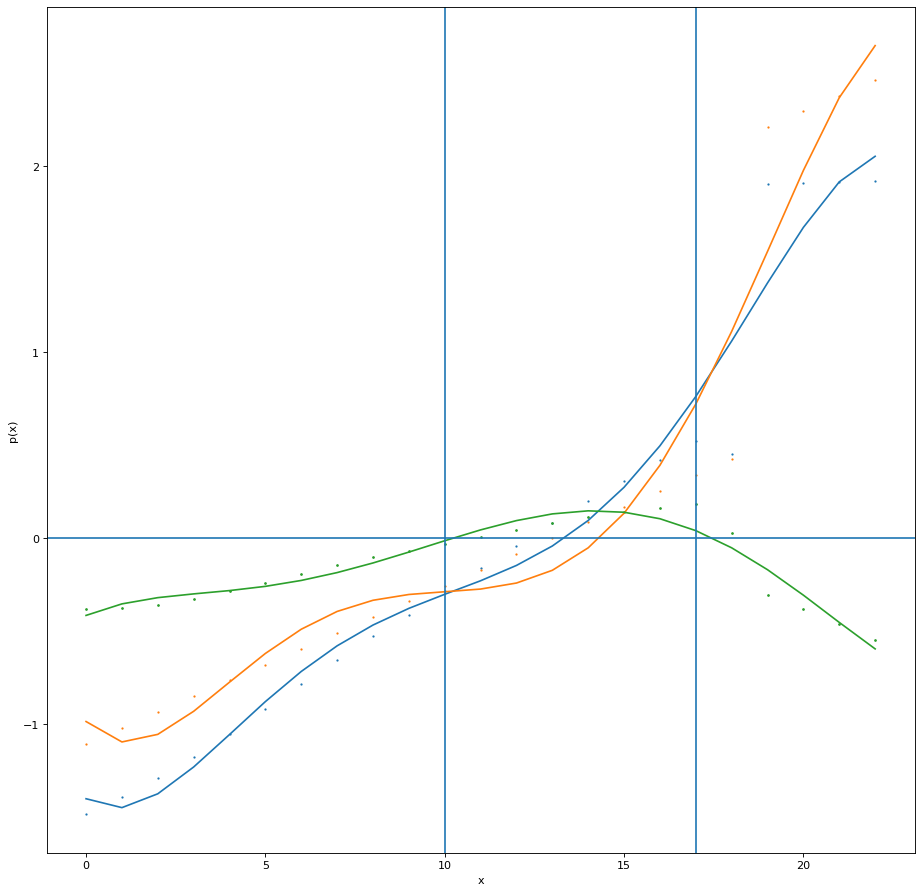

[10 17]
tensor([[0.4260, 0.4700],
        [0.6355, 0.5400]], grad_fn=<IndexBackward0>)
(0.4260353, 0.47) (0.63553375, 0.53999996)


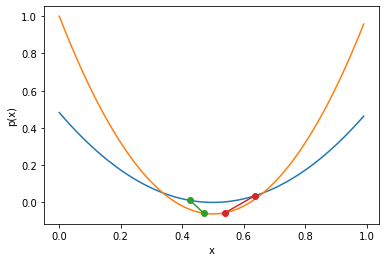

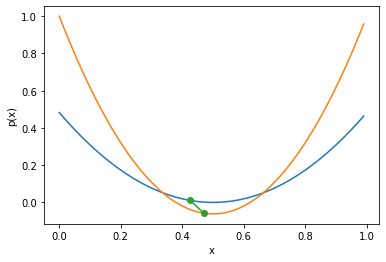

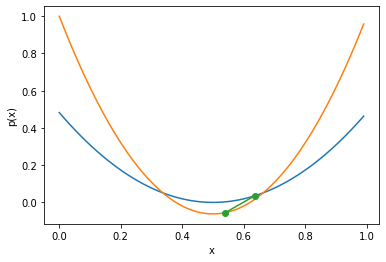

tensor([0.4333, 0.4723])


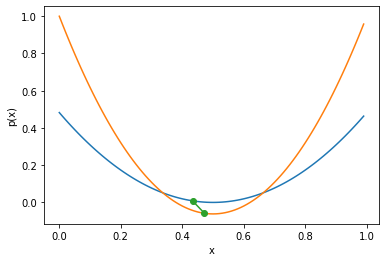

tensor([0.6265, 0.5448])


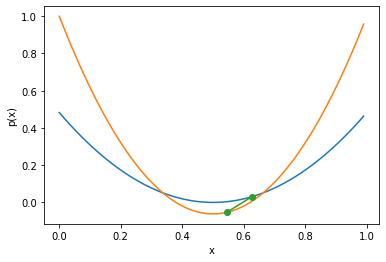

In [47]:
xp = out_
xq = x_

xpq = torch.vstack((xp, xq)).T

eqns_ = poly_set.get_values(xpq) - xpq * d_poly_set.get_values(xpq)
eqn_poly_set_ = PolynomialSet()
eqn_poly_set_.from_values(xpq, eqns_)

diff = eqn_poly_set_.diff(xpq, [0, 1])
idx_ = torch.where(abs(diff) < .5e-0)[0]
plt.figure(figsize=(14, 14), dpi=80)
plt.ylim(-1, 1)
plt.scatter(range(len(diff)), diff.detach(), s=1)
plt.show()

xp, xq = xp[idx_], xq[idx_]
xpq = torch.vstack((xp, xq)).T

deri = poly_set.get_values(xpq, o=1)
argmax = torch.argmax(deri, dim=-1)
diffs = torch.diff(argmax)
idx_diffs = torch.where(diffs != 0)[0]
print(argmax)
print(diffs)
print(idx_diffs)
print(xpq[idx_diffs])
print(xpq[idx_diffs + 1])
#idx_ = torch.where(abs(deri[:, 0].detach() - deri[:, 1].detach()) < 1)[0]
#xp, xq = xp[idx_], xq[idx_]
#xpq = torch.vstack((xp, xq)).T
deri = poly_set.get_values(xpq, o=1)

plt.figure(figsize=(14, 14), dpi=80)
poly_p = Polynomial()
poly_p.from_values(torch.arange(len(deri), dtype=torch.float), deri[:, 0], deg=5)
poly_p.plot(torch.arange(len(deri), dtype=torch.float))
poly_q = Polynomial()
poly_q.from_values(torch.arange(len(deri), dtype=torch.float), deri[:, 1], deg=5)
poly_q.plot(torch.arange(len(deri), dtype=torch.float))
poly_d = Polynomial()
poly_d.from_values(torch.arange(len(deri), dtype=torch.float), deri[:, 0] - deri[:, 1], deg=5)
poly_d.plot(torch.arange(len(deri), dtype=torch.float))
plt.scatter(range(len(deri)), deri[:, 0].detach(), s=1)
plt.scatter(range(len(deri)), deri[:, 1].detach(), s=1)
plt.scatter(range(len(deri)), deri[:, 0].detach() - deri[:, 1].detach(), s=2)
plt.grid()
roots = np.roots(poly_d.c.detach().numpy())
roots = roots[~np.iscomplex(roots)]
roots_float = np.sort(roots.astype(np.float32)[(roots > 0) & (roots < len(xpq))])
print(roots_float)
roots_f, roots_c = np.floor(roots_float), np.ceil(roots_float)
roots_f = np.unique(roots_f)
roots_c = np.unique(roots_c)
offset = (roots_float - roots_f).reshape(-1, 1)
print('floor:\n', xpq[roots_f])
print('ceiling:\n', xpq[roots_c])
adapted = ((xpq[roots_c] - xpq[roots_f]).detach() * offset + xpq[roots_f].detach()).float()
print(adapted)
print(poly_p.get_values(torch.from_numpy(roots_float)))
roots = np.unique(roots[(roots > 0) & (roots < len(xpq))]).astype(np.int)
for r in roots:
    plt.axvline(r)
plt.axhline(0)
plt.show()

xpq = xpq[roots]
print(roots)
print(xpq)
xp, xq = xpq[:, 0], xpq[:, 1]

print(*zip(xp.detach().numpy(), xq.detach().numpy()))
y = poly_set.get_values(xpq)
poly_set.plot(x)
plt.plot([xp.detach().numpy(), xq.detach().numpy()], [y[:, 0].detach().numpy(), y[:, 1].detach().numpy()], marker='o')
plt.show()

for xp_, xq_, y_ in zip(xp, xq, y):
    poly_set.plot(x)
    plt.plot([xp_.detach().numpy(), xq_.detach().numpy()], [y_[0].detach().numpy(), y_[1].detach().numpy()], marker='o')
    plt.show()
    
y = poly_set.get_values(adapted)
    
for xxx, yyy in zip(adapted, y):
    poly_set.plot(x)
    print(xxx)
    y = poly_set.get_values(xxx)
    plt.plot([xxx[0].detach(), xxx[1].detach()], [yyy[0].detach(), yyy[1].detach()], marker='o')
    plt.show()

In [39]:
print(eqn_poly_set_.get_values(xpq))
print(d_poly_set.get_values(xpq))

tensor([[ 0.4045,  0.3298],
        [-1.0412, -0.6490]], grad_fn=<CatBackward0>)
tensor([[-0.9246, -0.8250],
        [ 1.6942,  1.1000]], grad_fn=<CatBackward0>)


In [40]:
print(eqn_poly_set_.get_values(adapted))
print(d_poly_set.get_values(adapted))

tensor([[ 0.3699,  0.3016],
        [-0.9597, -0.7240]], grad_fn=<CatBackward0>)
tensor([[-0.8338, -0.7625],
        [ 1.5812,  1.2313]], grad_fn=<CatBackward0>)


In [52]:
x = np.arange(1e-10, 1., step=0.001)

f = x * np.log(x) + (1 - x) * np.log(1 - x)

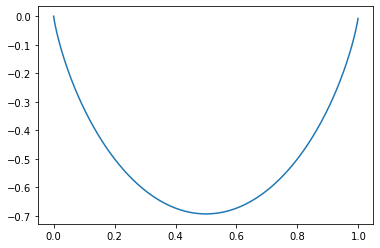

In [53]:
plt.plot(x, f)

In [57]:
f_ = np.log(x) + 1 - np.log(1 - x) + 1

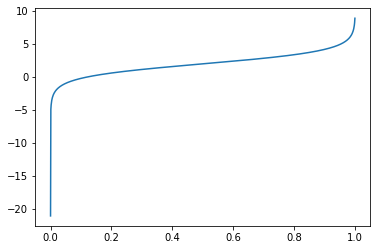

In [55]:
plt.plot(x, f_)